# Google Drive mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip3 install -r $ROOT_PATH/requirements.txt --quiet

# Imports and constants

In [2]:
import sys
sys.path.append("..")
from src.utils import get_filename, cropped_coins_path, side_path, aligned_coins_path,MARCINIAK_DATASET_PATH, NIEMCZYK_DATASET_PATH
import cv2

REF_IMG_DICT = {
    1: cv2.imread(cropped_coins_path(MARCINIAK_DATASET_PATH)+ "/35_1.jpg"),
    2: cv2.imread(cropped_coins_path(MARCINIAK_DATASET_PATH)+ "/35_2.jpg"),
}

In [3]:
import numpy as np

from tqdm.notebook import tqdm
from time import sleep
import pandas as pd
from src.detector import create_circular_mask 
from matplotlib import pyplot as plt
from scipy.spatial import distance

In [ ]:
%whos


# Alignment environment


In [3]:
DATASET_PATH = MARCINIAK_DATASET_PATH

src_im_orig = REF_IMG_DICT[2]
dst_im_orig = cv2.imread(cropped_coins_path(DATASET_PATH) + '/70_2.jpg')

src_h, src_w = src_im_orig.shape[:2]
dst_h, dst_w = dst_im_orig.shape[:2]

assert src_h == src_w
assert dst_h == dst_w

ds_size = 600
ds_src_ratio = ds_size / src_h 
ds_dst_ratio = ds_size / dst_h

src_im = cv2.resize(src_im_orig, (ds_size, ds_size))
dst_im = cv2.resize(dst_im_orig, (ds_size, ds_size))

In [4]:
sift = cv2.SIFT_create()

src_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
dst_gray = cv2.cvtColor(dst_im, cv2.COLOR_BGR2GRAY)

src_kp, src_des = sift.detectAndCompute(src_gray, None)
dst_kp, dst_des = sift.detectAndCompute(dst_gray, None)

## Best matching

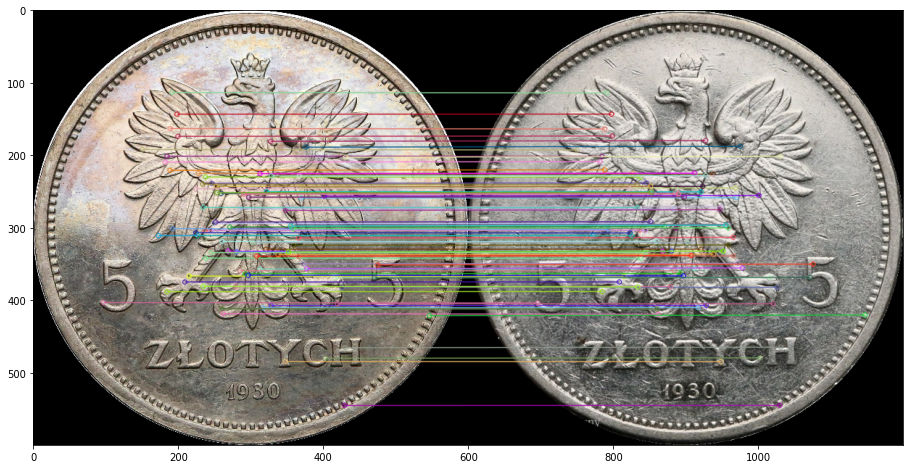

In [5]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.match(src_des, dst_des)
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:int(len(matches)*0.7)]
matches = sorted(matches, key = lambda x: distance.euclidean( src_kp[x.queryIdx].pt , dst_kp[x.trainIdx].pt))
matches = matches[:len(matches)][:100]

matches_im = cv2.drawMatches(cv2.cvtColor(src_im, cv2.COLOR_BGR2RGB), src_kp,
                             cv2.cvtColor(dst_im, cv2.COLOR_BGR2RGB), dst_kp,
                             matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16,8))
plt.imshow(matches_im)
plt.show()

In [6]:
src_pts = np.float32([ np.divide(src_kp[m.queryIdx].pt, ds_src_ratio) for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ np.divide(dst_kp[m.trainIdx].pt, ds_dst_ratio) for m in matches ]).reshape(-1,1,2)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
M, mask = cv2.estimateAffinePartial2D (src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold = 5.0)
matchesMask = mask.ravel().tolist()
M1 = M.copy()
scale = np.sqrt(M1[1,0]**2 + M1[0,0]**2)
M1[:2,:2] = np.transpose(M1[:2,:2]/scale) # R
M1[:2,2] = -M1[:2,2] # T

res_im = cv2.warpAffine(dst_im_orig, M1, (int(src_h*scale), int(src_h*scale)))
# res_im = cv2.warpPerspective(src_im_orig, M, (int(src_h*scale), int(src_h*scale)))
mask = create_circular_mask(int(src_h*scale), int(src_h*scale))
res_im[~mask] = 0

In [7]:
angle = np.degrees(np.arctan(M[1,0]/M[0,0]))
angle

-0.18381171016985343

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(res_im);

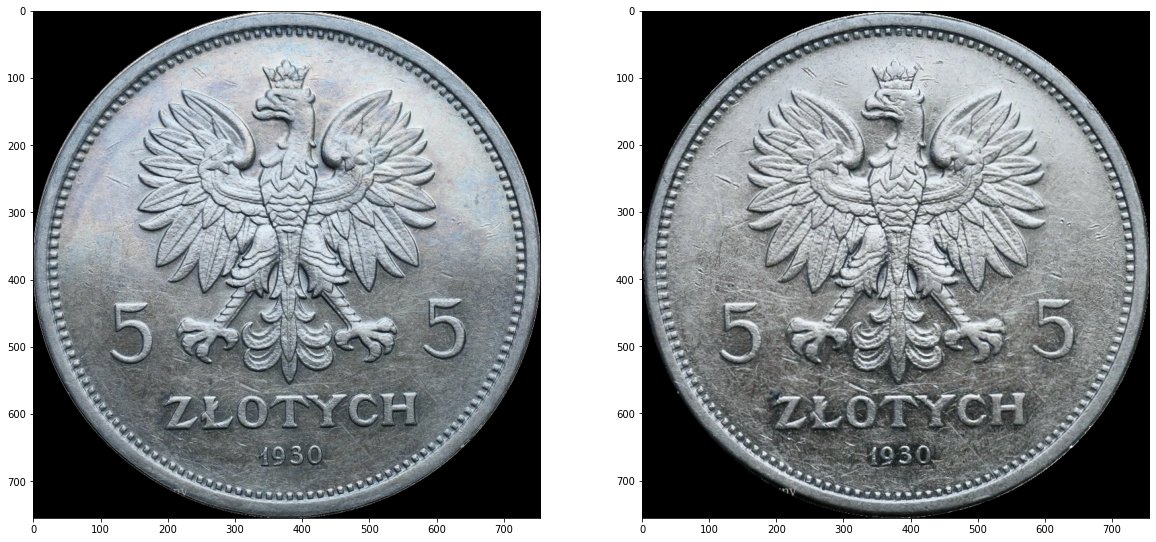

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(np.uint8(dst_im_orig * 0.5 + cv2.warpAffine(src_im_orig, M, (dst_h, dst_h)) * 0.5))
ax2.imshow(res_im)
plt.show()

# Final method

In [4]:
def align_with_reference(dst_im_orig, src_im_orig, ds_size = 600, matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)):
  src_h, src_w = src_im_orig.shape[:2]
  dst_h, dst_w = dst_im_orig.shape[:2]

  assert src_h == src_w
  assert dst_h == dst_w

  ds_size = min(ds_size, dst_h)
  ds_src_ratio = ds_size / src_h 
  ds_dst_ratio = ds_size / dst_h

  src_im = cv2.resize(src_im_orig, (ds_size, ds_size))
  dst_im = cv2.resize(dst_im_orig, (ds_size, ds_size))

  sift = cv2.SIFT_create()

  src_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
  dst_gray = cv2.cvtColor(dst_im, cv2.COLOR_BGR2GRAY)

  src_kp, src_des = sift.detectAndCompute(src_gray, None)
  dst_kp, dst_des = sift.detectAndCompute(dst_gray, None)

  matches = matcher.match(src_des, dst_des)
  # matches = sorted(matches, key = lambda x:x.distance)
  matches = sorted(matches, key = lambda x: distance.euclidean( src_kp[x.queryIdx].pt , dst_kp[x.trainIdx].pt))
  matches = matches[:50]

  MIN_MATCH_COUNT = 10

  if len(matches)>MIN_MATCH_COUNT:
      src_pts = np.float32([ np.divide(src_kp[m.queryIdx].pt, ds_src_ratio) for m in matches ]).reshape(-1,1,2)
      dst_pts = np.float32([ np.divide(dst_kp[m.trainIdx].pt, ds_dst_ratio) for m in matches ]).reshape(-1,1,2)
      # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
      M, mask = cv2.estimateAffinePartial2D (src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold = 5.0)
      # matchesMask = mask.ravel().tolist()
      scale = np.sqrt(M[1,0]**2 + M[0,0]**2)
      M[:2,:2] = np.transpose(M[:2,:2]/scale) # R
      M[:2,2] = -M[:2,2] # T

      res_im = cv2.warpAffine(dst_im_orig, M, (int(src_h*scale), int(src_h*scale)))
      mask = create_circular_mask(int(src_h*scale), int(src_h*scale))
      res_im[~mask] = 0

      return res_im
  else:
      print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
      matchesMask = None


In [5]:
def align_all_coins(csv_path, in_root, out_root, labels):
    df = pd.read_csv(csv_path)
    df["label"] = df["label"].astype("uint8")

    pbar = tqdm(total=len([l for l in df["label"] if l in labels]))

    for i, row in df.iterrows():
        name = row["name"]
        label = row["label"]
        if label not in labels:
            continue
        try:
            img = cv2.imread(in_root + "/" + name)
            ref_im = REF_IMG_DICT[label]
            aligned = align_with_reference(img, ref_im)
            cv2.imwrite(out_root + "/" + name, aligned)
        except:
            print('error', name)
            pass
        pbar.update(1)
    pbar.close()

In [9]:
DATASET_PATH = NIEMCZYK_DATASET_PATH
align_all_coins(side_path(DATASET_PATH), cropped_coins_path(DATASET_PATH), aligned_coins_path(DATASET_PATH), [1,2])

  0%|          | 0/916 [00:00<?, ?it/s]

## Errors

marciniak
127_2.jpg
33_2.jpg
76_2.jpg
91_2.jpg

76_1.jpg